# Basic classification models

* initial objectives:
  * fit several base models
  * candidates:  `logistic regression`, `decision tree`, `svm`, `random forest`, `gradient boosting`, `knn`, `naive bayes`, `neural networks`
  * 

## Import libraries and load functions

In [15]:
# import
import pandas as pd
from sklearn.preprocessing import StandardScaler

### functions
- [x] extract depresjon from folder
- [x] extract full days (1440 rows) records and minimum full records
- [ ] resample, e.g. to hourly
- [x] normalise data (mean = 0, std = 1)
- [ ] 

In [32]:
# load pl functions

%run ../code/pl-functions.py

## Data preprocessing

### Extract data from folder

In [33]:
# load the data
df = extract_folder('../data/depresjon')

In [34]:
# print head
#print(df.head())

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571706 entries, 0 to 1571705
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1571706 non-null  datetime64[ns]
 1   date       1571706 non-null  datetime64[ns]
 2   activity   1571706 non-null  int64         
 3   id         1571706 non-null  object        
 4   label      1571706 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 60.0+ MB
None


55


### Reduce dataset to full days only


In [35]:
# extract full days
df7 = extract_full_days(df, 7)

In [36]:
# print rows per id / 1440
#print(df7.groupby('id').size()/1440)

# print unique count of id
print(df7['id'].nunique())

# print days for each id
#num_days = df.groupby('id')['date'].nunique()
#print(num_days)

# print date range for condition_1 id
print(df7[df7['id'] == 'condition_1']['date'].min())
print(df7[df7['id'] == 'condition_1']['date'].max())

# print info
print(df7.info())



55
2003-05-08
2003-05-23
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527281 entries, 540 to 1570797
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1527281 non-null  datetime64[ns]
 1   date       1527281 non-null  object        
 2   activity   1527281 non-null  int64         
 3   id         1527281 non-null  object        
 4   label      1527281 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 69.9+ MB
None


### Resample - 

* I am skipping this optional step for now...I want to see if it runs on the complete df

### Normalise

In [37]:
# column to normalise
col_to_normlise = ['activity']

# normalise
df7_norm = normalise_data(df7, col_to_normlise)


C:\Users\zoona\OneDrive - UWE Bristol\DS Year 2\IGP-5\code\pl-functions.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_normalise] = scaler.fit_transform(df[columns_to_normalise])


In [39]:
# print head
#print(df.head())

# print info
print(df7_norm.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527281 entries, 540 to 1570797
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1527281 non-null  datetime64[ns]
 1   date       1527281 non-null  object        
 2   activity   1527281 non-null  float64       
 3   id         1527281 non-null  object        
 4   label      1527281 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 69.9+ MB
None


### Feature engineering

This model will be run on aggregated features:

* `mean`, `std`, `min`, `max`, `sum`
* `active_periods`, `inactive_periods`

#### Active - what is active?

* trying to understand what could constitute being active in this data - will need more reading (actigraphs, etc.)
* going to start with 0.5 as the threshold

In [42]:
# summary stats for activity (normalised)
print(df7_norm['activity'].describe())

count    1.527281e+06
mean     2.452713e-17
std      1.000000e+00
min     -4.993880e-01
25%     -4.993880e-01
50%     -4.882190e-01
75%      6.185239e-02
max      2.183854e+01
Name: activity, dtype: float64


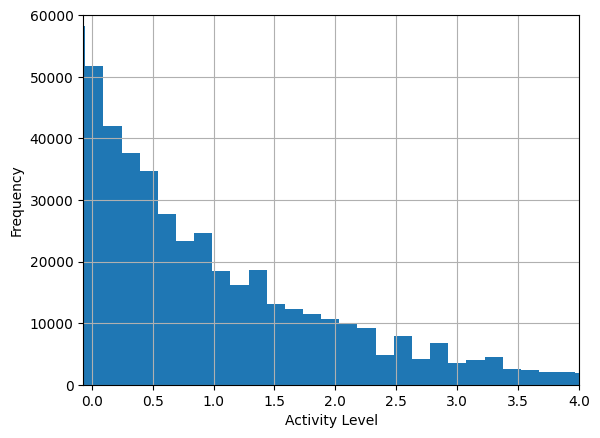

In [61]:
# plot activity histogram, zoom in on -0.07 to 0.07
import matplotlib.pyplot as plt
df7_norm['activity'].hist(bins=150)
plt.xlabel('Activity Level')
plt.ylabel('Frequency')
plt.xlim(-0.07, 4)  #  limits of the x-axis
plt.ylim(0, 60000)
plt.show()




In [62]:
def generate_features(df, activity_threshold=0.5):
    """
    Generate features for each subject in the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing timestamp, date, activity, id, and label columns.
    activity_threshold (float): The threshold to define active vs inactive periods.

    Returns:
    DataFrame: A DataFrame where each row corresponds to a subject and contains the generated features.
    """
    # Group the DataFrame by 'id' and 'date'
    groups = df.groupby(['id', 'date'])

    # Calculate basic statistics
    mean_activity = groups['activity'].mean()
    std_activity = groups['activity'].std()
    min_activity = groups['activity'].min()
    max_activity = groups['activity'].max()
    total_activity = groups['activity'].sum()

    # Calculate number of active and inactive periods
    active_periods = groups.apply(lambda x: (x['activity'] > activity_threshold).sum())
    inactive_periods = groups.apply(lambda x: (x['activity'] <= activity_threshold).sum())

    # Combine all features into a single DataFrame
    features = pd.concat([mean_activity, std_activity, min_activity, max_activity, total_activity, active_periods, inactive_periods], axis=1)
    features.columns = ['mean_activity', 'std_activity', 'min_activity', 'max_activity', 'total_activity', 'active_periods', 'inactive_periods']

    # Reset the index
    features.reset_index(inplace=True)

    # Get the label for each subject
    labels = df.groupby('id')['label'].first()
    features = features.merge(labels, left_on='id', right_index=True)

    return features


In [63]:
df7_feat = generate_features(df7_norm, activity_threshold=0.5)

In [64]:
print(df7_feat.head())


            id        date  mean_activity  std_activity  min_activity  \
0  condition_1  2003-05-08      -0.063108      0.639730     -0.499388   
1  condition_1  2003-05-09      -0.152772      0.589836     -0.499388   
2  condition_1  2003-05-10      -0.122542      0.644881     -0.499388   
3  condition_1  2003-05-11      -0.221729      0.496237     -0.499388   
4  condition_1  2003-05-12       0.385401      1.385467     -0.499388   

   max_activity  total_activity  active_periods  inactive_periods  label  
0      4.956650      -90.875703             238              1202      1  
1      4.169238     -219.991698             179              1261      1  
2      5.492760     -176.460668             174              1266      1  
3      5.308472     -319.289356             124              1316      1  
4      9.346052      554.977909             435              1005      1  


## Train / Test split

In [72]:
from sklearn.model_selection import train_test_split

"""
Split the dataset into training and testing sets.

Parameters:
    X (DataFrame): The input features.
    y (Series): The target variable.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): The seed used by the random number generator.

Returns:
    X_train (DataFrame): The training set of input features.
    X_test (DataFrame): The testing set of input features.
    y_train (Series): The training set of target variable.
    y_test (Series): The testing set of target variable.
"""
X = df7_feat.drop(['label', 'date', 'id'], axis=1)
y = df7_feat['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# info on train and test
print(X_train.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 328 to 860
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_activity     868 non-null    float64
 1   std_activity      868 non-null    float64
 2   min_activity      868 non-null    float64
 3   max_activity      868 non-null    float64
 4   total_activity    868 non-null    float64
 5   active_periods    868 non-null    int64  
 6   inactive_periods  868 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 54.2 KB
None


## Models

**Logistic Regression:**
LR is a statistical model used in binary classification by modelling the log-odds of the probability of an event.
* Strengths: Simple, fast, and efficient for small dataset with limited features.
* Weaknesses: Assumes a linear decision boundary, can underperform with complex datasets.

**Random Forest:**
* RF is an ensemble learning method constructs multiple decision trees at training time and outputting the class that is the mode of the classes of the individual trees.
* Strengths: Handles categorical variables well, resistant to overfitting, can model non-linear decision boundaries.
* Weaknesses: *Can be slow on large datasets*, not easily interpretable.

**Support Vector Machine (SVM):**
* SVM is a powerful and flexible class of supervised algorithms for both classification and regression.
* Strengths: Effective in high dimensional spaces, or when number of dimensions is greater than the number of samples.
* Weaknesses: Does not directly provide probability estimates, can be *inefficient to train*.
  
**Decision Tree:**
* DT are a type of simple flowchart-like structure in which internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome.
* Strengths: Simple to understand and interpret, requires little data preparation.
* Weaknesses: Prone to overfitting, can create biased trees if some classes dominate.

**K-Nearest Neighbors (KNN):**
* KNN is a type of *instance-based learning, or lazy learning*, where the function is only approximated locally and all computation is deferred until function evaluation.
* Strengths: Simple, effective for datasets with complex decision boundaries.
* Weaknesses: *Slow on large datasets*, sensitive to irrelevant features.

**Naive Bayes:**
* NB classifiers are a family of simple “probabilistic classifiers” based on applying Bayes’ theorem with strong (naïve) independence assumptions between the features.
* Strengths: Fast, simple, performs well with small datasets.
* Weaknesses: *Assumes that all features are independent*, which is rarely the case.

**Neural Network (MLPClassifier):**
* MLPClassifier stands for Multi-layer Perceptron classifier connects to a Neural Network. MLPClassifier relies on an underlying Neural Network to perform the task of classification.
* Strengths: Can model complex, non-linear patterns.
* Weaknesses: *Requires a lot of data and computational resources, not easily interpretable.*

**XGBoost**:
* XGBoost is an optimised distributed gradient boosting library designed to be highly efficient, flexible and portable.
* Strengths: Fast, accurate, supports regularisation to avoid overfitting.
* Weaknesses: *Can be slow to train*, not easily interpretable.

**LightGBM**:
* LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages: Faster training speed and higher efficiency, lower memory usage, better accuracy, support of parallel and GPU learning, capable of handling large-scale data.
* Strengths: Fast, uses less memory, higher accuracy.
* Weaknesses: Can overfit on small datasets, not easily interpretable.

**AdaBoost**:
* AdaBoost is a boosting algorithm which constructs a classifier. Adaboost creates a strong classifier from number of weak classifiers.
* Strengths: Fast, simple, less prone to overfitting.
* Weaknesses: Sensitive to noisy data and outliers.

**Quadratic Discriminant Analysis (QDA):**
* QDA is a classifier with a quadratic decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
* Strengths: Can model more complex decision boundaries than linear methods.
* Weaknesses: *Assumes that the observations are normally distributed*, which is rarely the case.

In [ ]:
#%pip install xgboost
#%pip install lightgbm

## Import model libraries

In [66]:
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix


## Set up models, in sets (not sure how long they take to run)

In [76]:
# full set
models = [
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier())
]


# models set 1
models1 = [
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),    
]


models_2 = [
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    
]

models_3 = [
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),  
]

models_4 = [
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()), 
    ('Gradient Boosting', GradientBoostingClassifier())
]

## Model evaluation function

In [69]:

results = []

def evaluate_models(models, X_train, y_train, X_test, y_test):
    """
    Evaluate the performance of different models on a given dataset.

    Parameters:
    - models (list): A list of tuples containing the name and model object.
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Test data features.
    - y_test (array-like): Test data labels.

    Returns:
    - results (list): A list of dictionaries containing the evaluation results for each model.
    """
    import time
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

    for name, model in models:
        start_time = time.time()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        end_time = time.time()
        elapsed_time = end_time - start_time

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)

        print(f'{name}:')
        print(f'Time taken: {elapsed_time} seconds')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Matthews Correlation Coefficient: {mcc}')
        print(f'Confusion Matrix: {cm}')
        print(f'Classification Report: {cr}')
        print(cr)

        results.append({
            'name': name,
            'time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'confusion_matrix': cm,
            'classification_report': cr
        })

    return results



* understanding /summarising each model, strengths/weakness, description


## Models

In [77]:
# evaluate models
results = evaluate_models(models, X_train, y_train, X_test, y_test)

Random Forest:
Time taken: 0.1890108585357666 seconds
Accuracy: 0.6880733944954128
Precision: 0.5909090909090909
Recall: 0.4875
F1 Score: 0.5342465753424658
Matthews Correlation Coefficient: 0.3061591458912443
Confusion Matrix: [[111  27]
 [ 41  39]]
Classification Report:               precision    recall  f1-score   support

           0       0.73      0.80      0.77       138
           1       0.59      0.49      0.53        80

    accuracy                           0.69       218
   macro avg       0.66      0.65      0.65       218
weighted avg       0.68      0.69      0.68       218

              precision    recall  f1-score   support

           0       0.73      0.80      0.77       138
           1       0.59      0.49      0.53        80

    accuracy                           0.69       218
   macro avg       0.66      0.65      0.65       218
weighted avg       0.68      0.69      0.68       218

SVM:
Time taken: 0.016664981842041016 seconds
Accuracy: 0.66055045871559

In [ ]:


def evaluate_models(models, X_train, y_train, X_test, y_test):
    """
    Evaluate multiple models using cross-validation and generate predictions on the test data.

    Parameters:
    - models (list): A list of tuples containing the name and model object for each model to be evaluated.
    - X_train (array-like): The training data features.
    - y_train (array-like): The training data labels.
    - X_test (array-like): The test data features.
    - y_test (array-like): The test data labels.

    Returns:
    - results (list): A list of dictionaries containing the evaluation results for each model.
    Each dictionary contains the following keys:
        - 'name': The name of the model.
        - 'time': The time taken to train and predict.
        - 'accuracy': The accuracy score.
        - 'precision': The precision score.
        - 'recall': The recall score.
        - 'f1': The F1 score.
        - 'mcc': The Matthews Correlation Coefficient.
        - 'confusion_matrix': The confusion matrix.
        - 'classification_report': The classification report.
    """

    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
    
    results = []

    for name, model in models:
        start_time = time.time()

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f'{name} cross-validation score: {cv_scores.mean()} ± {cv_scores.std()}')

        # Fit the model on the training data and generate predictions on the test data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'{name} took {elapsed_time} seconds to train and predict\n')

        # Calculate metrics here (accuracy, precision, recall, etc.)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)

        print(f'{name}:')
        print(f'Time taken: {elapsed_time} seconds')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Matthews Correlation Coefficient: {mcc}')
        print(f'Confusion Matrix: {cm}')
        print(f'Classification Report: {cr}')

        results.append({
            'name': name,
            'time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'confusion_matrix': cm,
            'classification_report': cr
        })

    return results





## Visualise results


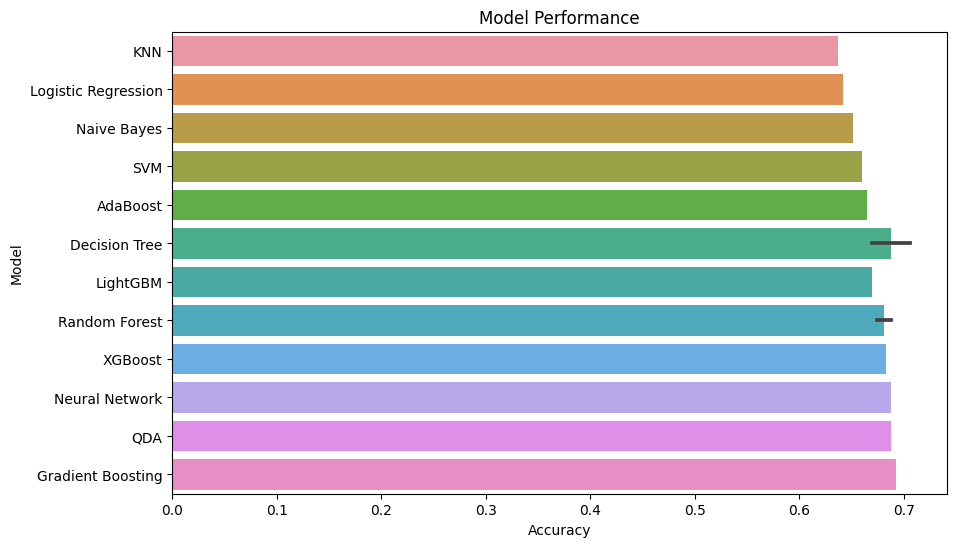

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Create a bar plot of the accuracy of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='accuracy', y='name', data=results_df.sort_values('accuracy'))
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Performance')
plt.show()


In [79]:
# Assume `cm` is the confusion matrix and `model_name` is the name of the model
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


NameError: name 'cm' is not defined

<Figure size 600x600 with 0 Axes>

## Extras

## Cross validation variation - not run - will be resource/time intensive 

### Gaussian processes

In this code, RBF(1.0) creates an RBF kernel with a length scale of 1.0, and GaussianProcessClassifier(kernel=kernel, random_state=0) creates a Gaussian process classifier using this kernel.

* an replace RBF(1.0) with `DotProduct()`, `Matern()`, `RationalQuadratic()`, or `WhiteKernel()` to use a different kernel.
* computationally intensive, especially on large datasets -> start with a subset of data

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel

# models
random_state = 0
model = [
    ('Gaussian Process with RBF kernel', GaussianProcessClassifier(kernel=RBF())),
    ('Gaussian Process with DotProduct kernel', GaussianProcessClassifier(kernel=DotProduct())),
    ('Gaussian Process with Matern kernel', GaussianProcessClassifier(kernel=Matern())),
    ('Gaussian Process with RationalQuadratic kernel', GaussianProcessClassifier(kernel=RationalQuadratic())),
    ('Gaussian Process with WhiteKernel', GaussianProcessClassifier(kernel=WhiteKernel()))
]

# evaluate models
for name, model in model:
    start_time = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    end_time = time.time()
    elapsed_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print(f'{name}:')
    print(f'Time taken: {elapsed_time} seconds')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Matthews Correlation Coefficient: {mcc}')
    print(f'Confusion Matrix: {cm}')
    print(f'Classification Report: {cr}')
    print(cr)

    results.append({
        'name': name,
        'time': elapsed_time,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'confusion_matrix': cm,
        'classification_report': cr
    })

In [ ]:

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0)
gpc.fit(X_train, y_train)

y_pred = gpc.predict(X_test)


### Keras, TensorFlow, Deep Learning 

* RNN - recurrent neural networks
* CNN - convolutional neural network

* **Bidirectional** - wrapper for RNN layer like LSTM or GRU
* **Flatten**: This layer is used to flatten the structure into a one-dimensional vector.
* **TimeDistributed**: This wrapper allows a layer to be applied to every temporal slice of an input. 
* **Conv1D**: This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. It’s often used in tasks involving sequences, such as text classification or time-series analysis.
* **MaxPooling1D**: This layer applies a max pooling operation for temporal data to reduce the dimensionality of the data.
* **ConvLSTM2D**: This layer is a type of LSTM layer where the recurrent connections are convolutional. 
* **backend** (K): This is a utility to provide backend-agnostic operations. 

* **sequence** from `keras.preprocessing`: This module provides functions to prepare time-series actigraphy data for the model.
* **ConfigProto** and **Session** from `tensorflow`: These are used to configure TensorFlow and create a TensorFlow session - for gpu use
* **Sequential** from `keras.models`: This is a linear stack of layers that to create a neural network. add layers to the network using the .add() method.
* **Dense**, **LSTM**, and **Dropout** from `keras.layers`: These are different types of layers can add to your neural network. Dense is a fully connected layer, LSTM is a type of recurrent layer suitable for sequence data, and Dropout is a regularization layer that helps prevent overfitting.
* **Adam** from `keras.optimizers`: This is an optimisation algorithm to train your neural network.  efficiency and low memory requirements
* **load_model** from `keras.models`: This function allows you to load a saved model - saves retraining
* **ModelCheckpoint** from `keras.callbacks`: This is a callback that you can use to save the model at regular intervals during training. This can be useful if training takes a long time and you don’t want to lose your progress if it’s interrupted.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, TimeDistributed, Conv1D, MaxPooling1D

# Define the model
model = Sequential()

# Add layers
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')
